## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## STEP1:Compute the camera calibration using chessboard images

### 1.0 Dependenies

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Load images
Load the images for camera calibration.

In [2]:
pat_camera_cal = 'camera_cal/'
name_images = os.listdir(pat_camera_cal)
fullPath_images = ['{0}{1}'.format(pat_camera_cal, name_image) for name_image in name_images]

In [3]:
len(fullPath_images)

20

### 1.2 Compute camera calibration

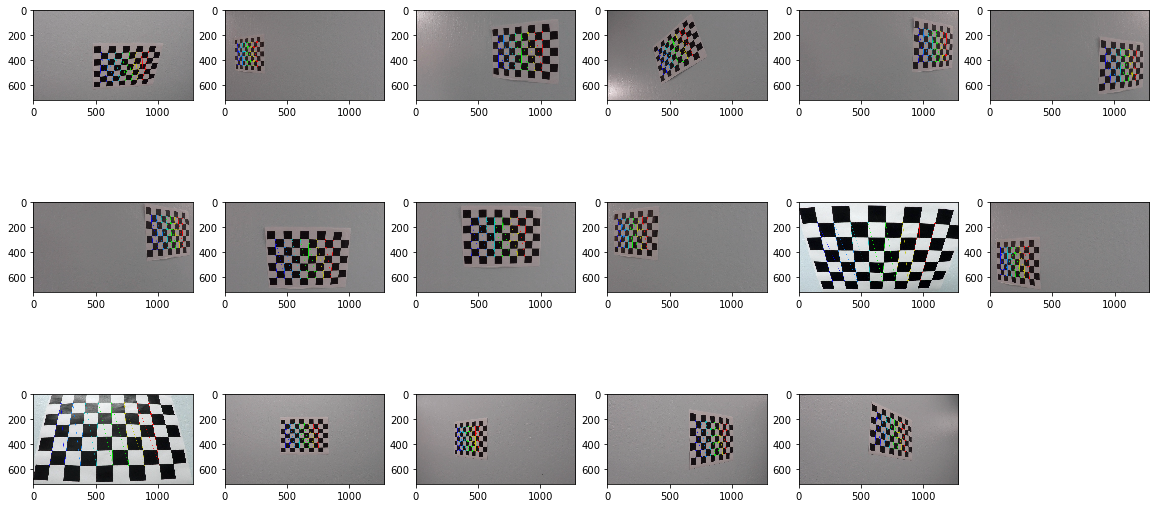

In [4]:
nx = 6
ny = 9

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
chessFound_imgs = [] # Images that are found chess boards


# Step through the list and search for chessboard corners
for index, fullpath_image in enumerate(fullPath_images):
    
    img = cv2.imread(fullpath_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        chessFound_imgs.append(img)

      
f, axs = plt.subplots(3, 6, figsize=(20, 10))
axs[-1][-1].remove() # There were 18 cells but only 17 cells are needed, remove the last one.

for index, image in enumerate(chessFound_imgs):
    idx_row = index // 6
    inx_col = index % 6
    axs[idx_row][inx_col].imshow(image)

### 1.2.5 Camera calibration

In [5]:
# Do camera calibration given object points and image points       
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)

### 1.3 Test undistortion on an image
Let's see how camera calibration works on chessboard image, would it correct the camera distortion ?

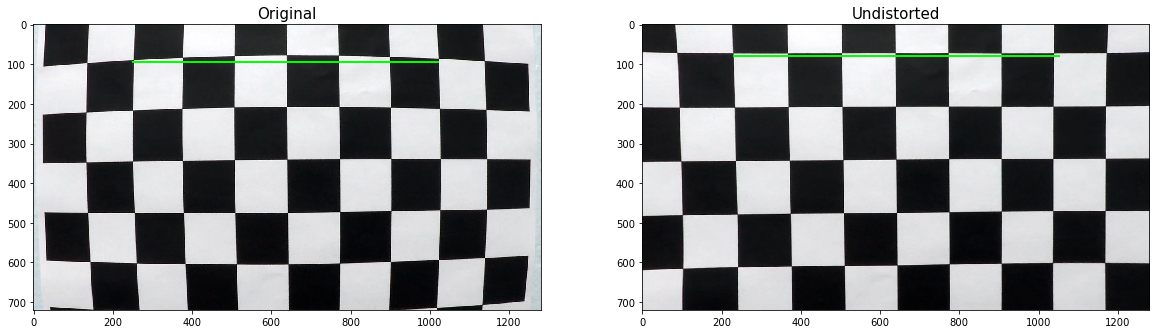

In [6]:
img = cv2.imread(fullPath_images[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.line(img, (250, 95), (1020, 95), (0, 255, 0), 3) # Draw a straight line to see the effects of camera distrotion
ax1.imshow(img)
ax1.set_title('Original', fontsize=15)

cv2.line(dst, (230, 80), (1050, 80), (0, 255, 0), 3) # Draw a straight line to see how the camera calibration worked out
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=15)

## Step2: Laneline extraction & bird view

### Helper functions
Helper functions to apply filters on images.

In [43]:
def BGR2HLS(image, channel = None, lowbound = 90, highbound = 255):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    channels = {
                 'h' : hls[:,:,0],
                 'l' : hls[:,:,1],
                 's' : hls[:,:,2],
               }
    
    if channel != None:
        target_channel = channels.get(channel)
        assert target_channel != None, 'By selecting the target channel, please type in "h" or "l" or "s".'
        binary_output = np.zeros_like(target_channel)
        binary_output[(target_channel > lowbound) & (target_channel <= highbound)] = 1
        return binary_output
    else:
        return channels['h'], channels['l'], channels['s']
    
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,  ksize = sobel_kernel)
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    g_dir = np.arctan2(sobely_abs, sobelx_abs)
    binary_output = np.zeros_like(g_dir)
    binary_output[(g_dir >= thresh[0]) & (g_dir <= thresh[1])] = 1
    return binary_output

def magnitude_threshold(image, size_kernel = 3, threshold = (100, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = size_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = size_kernel)
    sobel_abs = np.sqrt(sobel_x**2 + sobel_y**2)
    binary_output = np.zeros_like(sobel_abs)
    binary_output[(sobel_abs <= threshold[1]) & (sobel_abs >= threshold[0])] = 1
    return binary_output

def sobel_threshold(image, direct = 'x', size_kernel = 3, threshold = (90, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if direct =='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = size_kernel)
    if direct =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = size_kernel)
    sobel = np.absolute(sobel)
    sobel_rescaled = np.uint8(sobel/np.max(sobel)*255)    
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel <= threshold[1]) & (sobel >= threshold[0])] = 1
    return binary_output

def perspective_transform(image, src, dst):
    image_size = image.shape[::-1]
    src = np.float32(src)
    dst = np.float32(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, image_size)
    return warped

def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## 2.1 Filters visualization
By seeing the filters, we can find what filters suit our need.

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # This is added back by InteractiveShellApp.init_path()


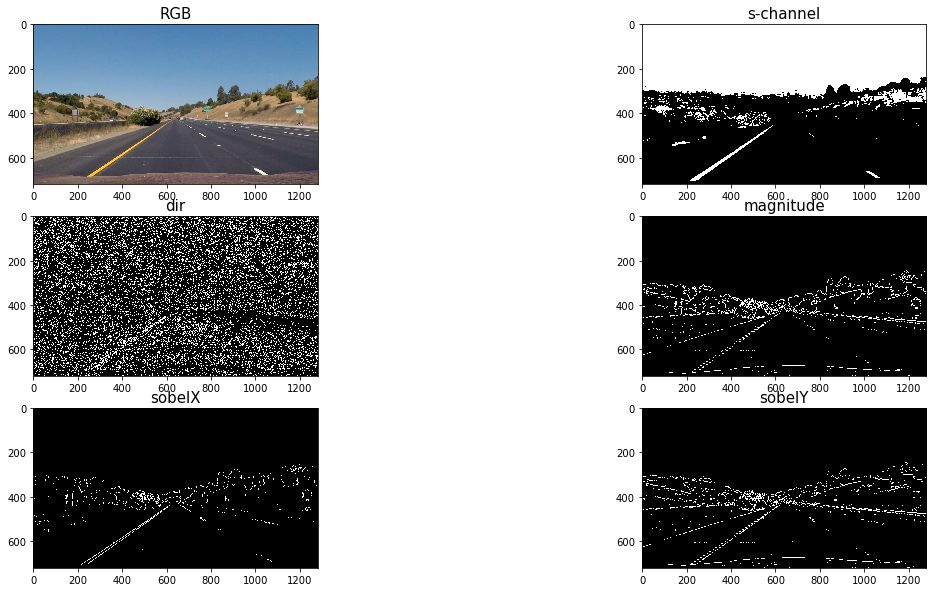

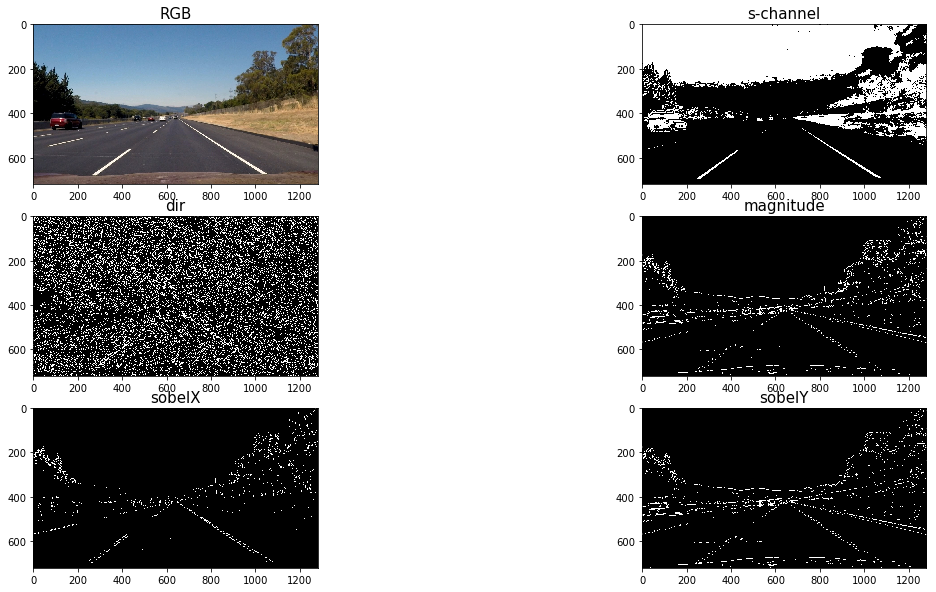

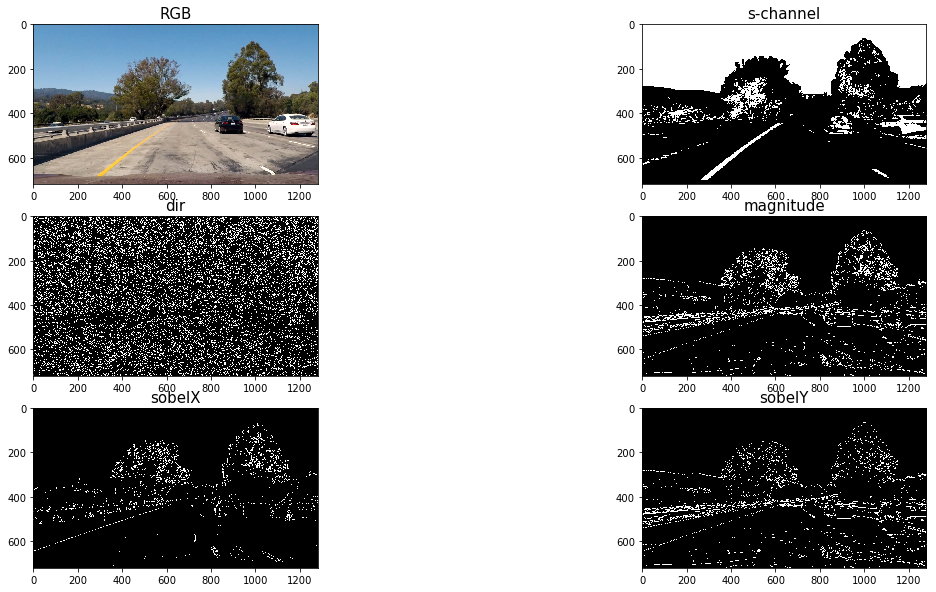

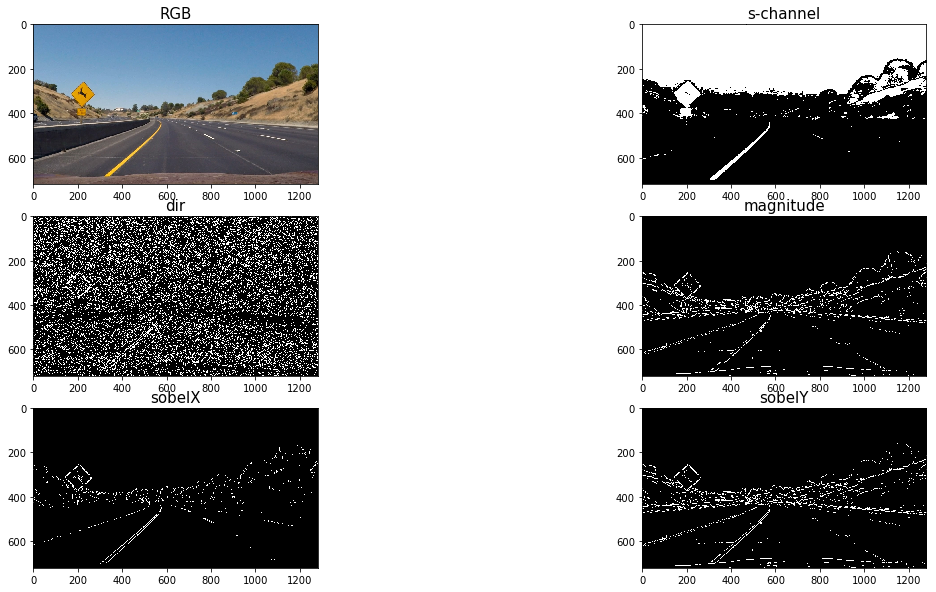

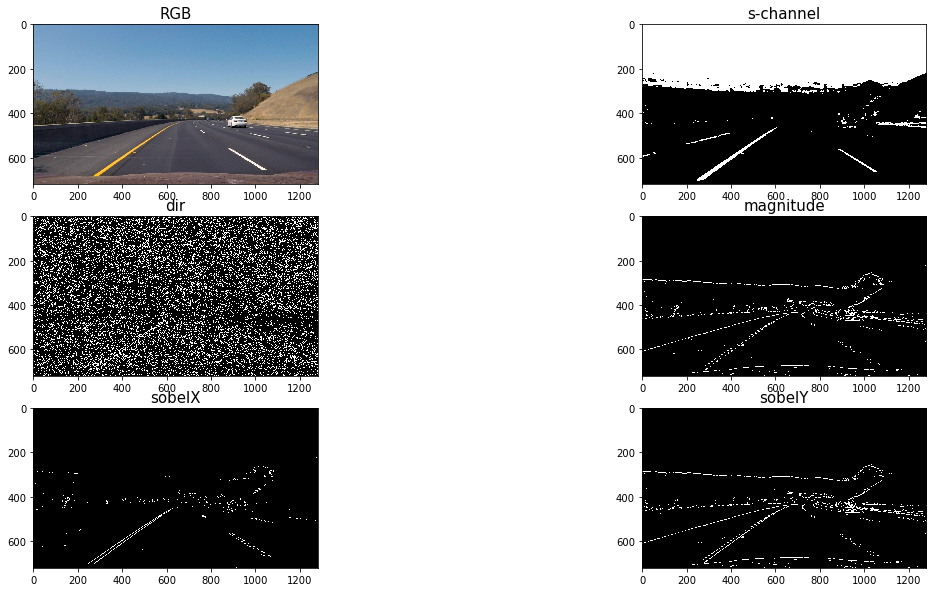

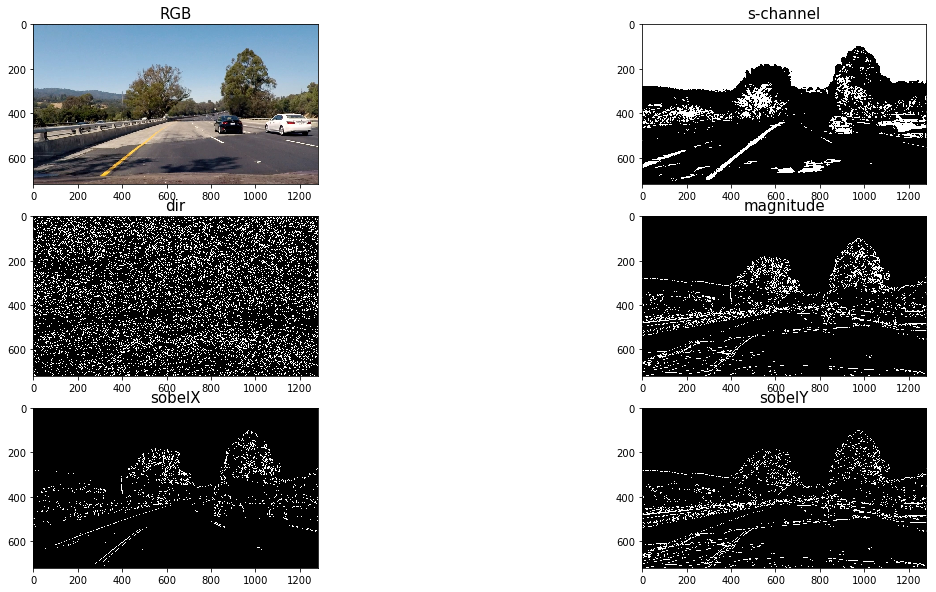

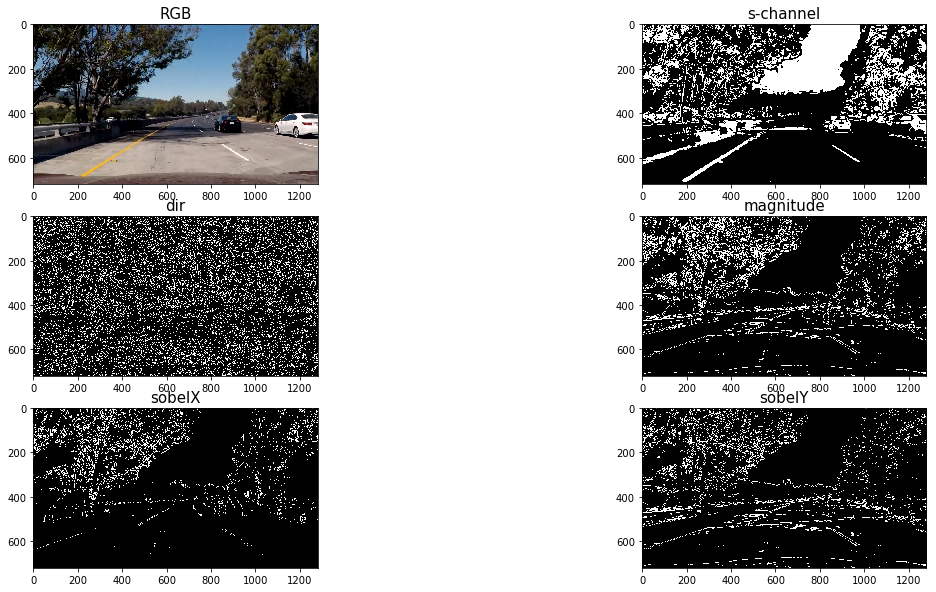

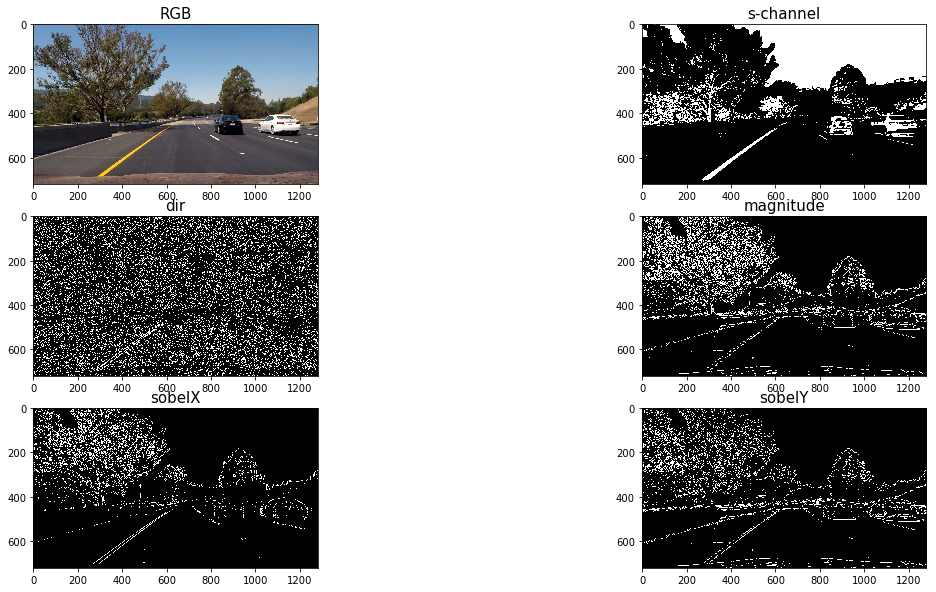

In [46]:
import os

## Load test images
path = 'test_images/'
name_testImgs = os.listdir(path)
name_testImgs = ['{0}{1}'.format(path, image) for image in name_testImgs]

## Loop through the whole images and apply filters on them
for name_testImg in name_testImgs:

    img = cv2.imread(name_testImg)
    rgb_img = GBR2RGB(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax0, ax1, ax2) = plt.subplots(3, 2, figsize=(20,10))
    
    # raw image
    ax0[0].imshow(rgb_img)
    ax0[0].set_title('RGB', fontsize=15)
    
    # s channel
    ax0[1].imshow(BGR2HLS(dst, channel='s'), cmap='gray')
    ax0[1].set_title('s-channel', fontsize=15)
    
    # direction
    ax1[0].imshow(dir_threshold(dst), cmap='gray')
    ax1[0].set_title('dir', fontsize=15)

    # magnitude
    ax1[1].imshow(magnitude_threshold(dst), cmap='gray')
    ax1[1].set_title('magnitude', fontsize=15)

    # sobelX
    ax2[0].imshow(sobel_threshold(dst), cmap='gray')
    ax2[0].set_title('sobelX', fontsize=15)

    # sobel Y
    ax2[1].imshow(sobel_threshold(dst, direct='y'), cmap='gray')
    ax2[1].set_title('sobelY', fontsize=15)

## Line searching

In [65]:
def lineSearching(warped, histogram, n_window = 9):
    midpoint = np.int(warped.shape[1]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    n_windows = 9
    window_height = np.int(warped.shape[0] / n_windows)
    
    nonezeros = warped.nonzero()
    nonzero_row = nonezeros[0]
    nonzero_column = nonezeros[1]
    
    left_current = leftx_base
    right_current = rightx_base
    
    margin = 100
    num_minpixels = 100
    left_laneIds = []
    right_laneIds = []
    
    nonezero = warped.nonzero()
    nonzeroy = np.array(nonezero[0])
    nonzerox = np.array(nonezero[1])
    
    clone = warped.copy()
    output = np.dstack((warped, warped, warped))
    
    for i in range(n_windows):
        window_y_low = warped.shape[0] - ((i + 1) * window_height)
        window_y_high = warped.shape[0] - (i * window_height)


        window_x_left_low = left_current - margin
        window_x_left_high = left_current + margin

        window_x_right_low = right_current - margin
        window_x_right_high = right_current + margin


        cv2.rectangle(output, (window_x_left_low, window_y_low), (window_x_left_high, window_y_high), (0, 255, 0), 3)
        cv2.rectangle(output, (window_x_right_low, window_y_low), (window_x_right_high, window_y_high), (0, 255, 0), 3)

        pixels_at_left = ((window_y_low < nonzeroy) & (window_y_high >= nonzeroy) & (window_x_left_low < nonzerox) & (window_x_left_high >= nonzerox)).nonzero()[0]
        pixels_at_right = ((window_y_low < nonzeroy) & (window_y_high >= nonzeroy) & (window_x_right_low < nonzerox) & (window_x_right_high >= nonzerox)).nonzero()[0]


        left_laneIds.append(pixels_at_left)
        right_laneIds.append(pixels_at_right)

        if len(pixels_at_left) > num_minpixels:
            left_current = np.int(np.mean(nonzerox[pixels_at_left]))

        if len(pixels_at_right) > num_minpixels:
            right_current = np.int(np.mean(nonzerox[pixels_at_right]))
        
    return output

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # This is added back by InteractiveShellApp.init_path()


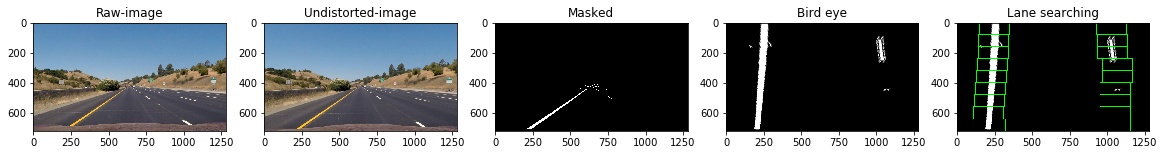

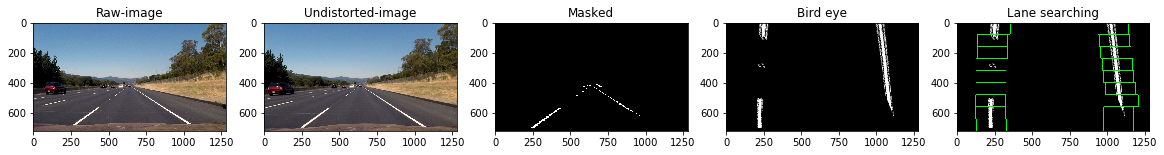

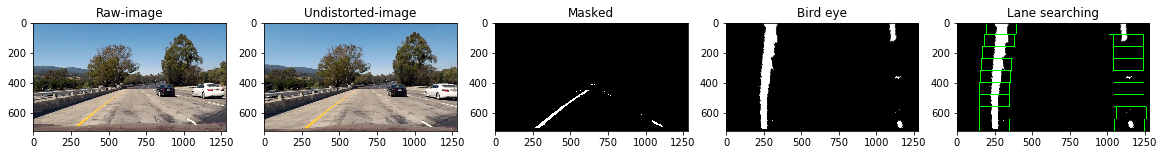

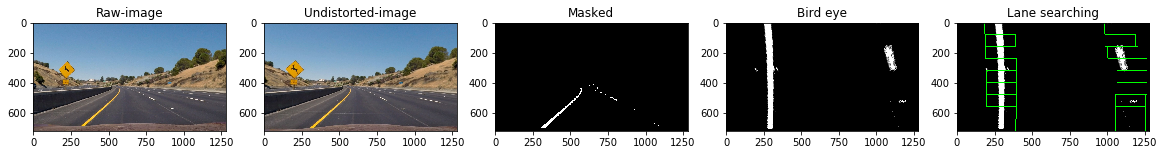

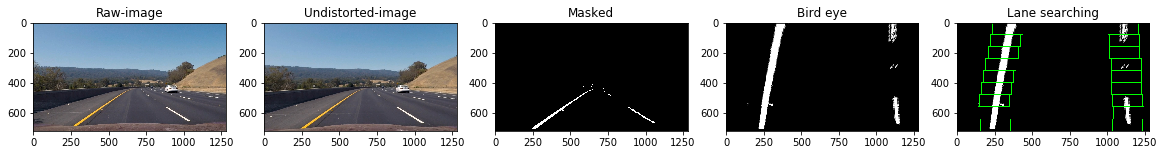

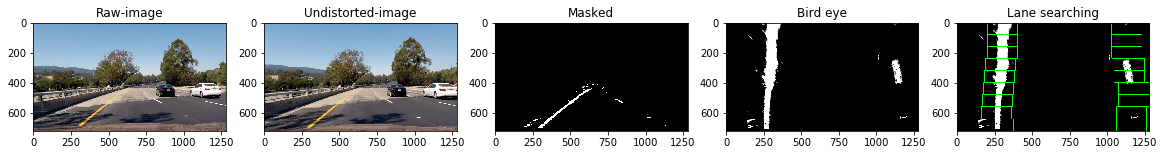

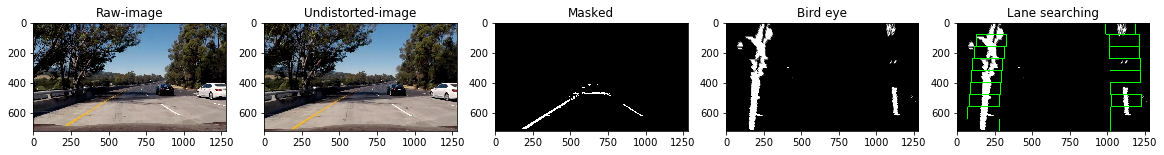

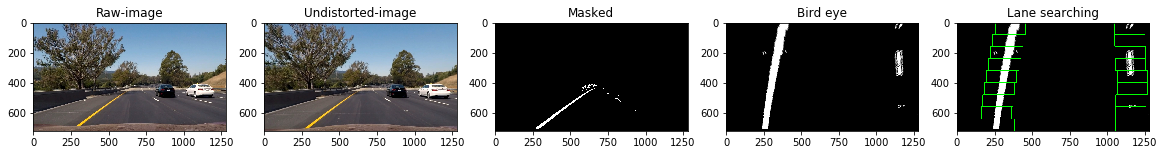

In [70]:
def pipeline(img): 
    imshape = img.shape
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)
    s_channel = BGR2HLS(undistorted_img, channel='s')    
    mag = magnitude_threshold(undistorted_img)    
    sobel_x = sobel_threshold(undistorted_img)    
    sobel_y = sobel_threshold(undistorted_img, direct='y')    
    
    combined = np.zeros_like(gray)
    combined[((s_channel == 1 ) | (sobel_x == 1))] = 255
    
    # Masked area
    left_bottom = (150, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    mask = np.zeros_like(combined)  
    
    mask = cv2.fillPoly(mask, vertices, (255, 255, 255))
    masked_image = cv2.bitwise_and(combined, mask)
    
    cv2.circle(immm, (200, 700), 5, (255, 0, 0), 3)
    cv2.circle(immm, (1080, 700), 5, (255, 0, 0), 3)
    cv2.circle(immm, (750, 480), 5, (255, 0, 0), 3)
    cv2.circle(immm, (540, 480), 5, (255, 0, 0), 3) 
    src_points = [
           (540, 480),
           (750, 480),
           (1080, imshape[0]),
           (200, imshape[0])]

    dst_points = [(200, 0),
           (1080, 0),
           (1080, imshape[0]),
           (200, imshape[0])]
    
    pt = perspective_transform(masked_image, src_points, dst_points)
    histogram = np.sum(pt[pt.shape[0]//2:,:], axis=0)
    laneFinding = lineSearching(pt, histogram, n_window = 9)
    return undistorted_img, masked_image, pt, histogram, laneFinding

for image in name_testImgs:
    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20,10))    
    raw_image = cv2.imread(image)        
    dst, masked, per, his, laneFinding = pipeline(raw_image)
    
    ax0.imshow(GBR2RGB(raw_image))
    ax0.set_title('Raw-image')
    
    ax1.imshow(BGR2RGB(dst))
    ax1.set_title('Undistorted-image')
    
    ax2.imshow(masked, cmap='gray')
    ax2.set_title('Masked')
    
    ax3.imshow(per, cmap='gray')
    ax3.set_title('Bird eye')
    
    ax4.imshow(laneFinding)
    ax4.set_title('Lane searching')
    


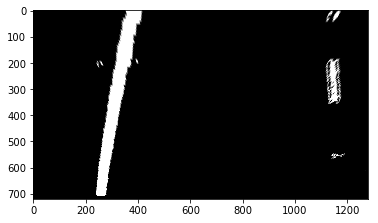

In [58]:
plt.imshow(np.dstack((per, per, per)))